## Problem statement:

More information about features: 

   1.  https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
   2. https://www.hindawi.com/journals/bmri/2014/781670/
   3. Features formation: https://www.hindawi.com/journals/bmri/2014/781670/tab1/


So this week we have a problem coming to us from the medical community. We're looking specifically at a diabetes study. And the problem is hospital readmission.

Now we don't want people in hospitals. We want them to be well. And we certainly don't want them to be readmitted. This comes at a huge cost to the patient in terms of bills, lost wages, strain on their family and whatnot. So our goal is no readmission.


***Predict readmission of the patient within 30 days of initial hospitalization.***


Import libraries 

In [1]:
#for data
import pandas as pd 
import numpy as np 

# scikit-learn's SimpleImputer to replace "nan" values
from sklearn.impute import SimpleImputer

# Display all columns 
pd.options.display.max_columns = None
## for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings("ignore")
import time

#### Common Functions

In [96]:
#This funtion will group Diagnostic columns into CD-9-CM Chapters Code Range
#Ref:https://icd.codes/icd9cm
def groupDiagnosticColumns(df_full, diagnostic_column_name):
    df_temp = df_full
    df_temp[diagnostic_column_name] = df_full[diagnostic_column_name].str.replace('V','1000')
    df_temp[diagnostic_column_name] = df_temp[diagnostic_column_name].str.replace('E','1000')
    df_temp[diagnostic_column_name] = df_temp[diagnostic_column_name].astype(str).astype(float)
    cut_bins =[1, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739,759, 779, 799, 999, 100091, 2000999]
    cut_diagnose_code_range = ['001-139', '140-239', '240-279', '280-289', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '740-759', '760-779', '780-799', '800-999', 'V01-V91', 'E000-E999']
    df_full[diagnostic_column_name + '_Cat'] = pd.cut(df_temp[diagnostic_column_name], bins=cut_bins, labels = cut_diagnose_code_range)

    
def categorical_explanatory_binary_response_chart(chart_df, field, target, toggle=False, ):
    # the toggle switches which class is the "baseline" of the line chart
    drop_index = 2
    if toggle:
        drop_index = 1
    
    field_count  = chart_df[field].value_counts()
    field_count_df = field_count.to_frame()
    field_count_df.columns = ['count']
    
    field_target_pct = pd.crosstab(chart_df[field], chart_df[target], normalize='index') * 100
    field_target_pct = field_target_pct.reset_index()
    field_target_pct = field_target_pct.drop(field_target_pct.columns[-drop_index],axis=1)
    
    field_target_data = field_target_pct.merge(field_count_df, right_index=True, left_on=field).sort_values('count', ascending=False).reset_index(drop=True)
    
    print(field_target_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel(field)
    ax = sns.barplot(field_target_data[field], field_target_data['count'], alpha=0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_ylabel('count (bars)')
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x=field_target_data[field], y=field_target_data.iloc[:, -2], color='black', legend=False)
    ax2.set_ylabel('% {t} (line)'.format(t = target))
    plt.show()

# this feature will impute the some of missing data features
def impute_Features(feature_name, df_impute):
    fill_nan_payer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    df_impute[feature_name] = fill_nan_payer.fit_transform(df_impute.loc[:,feature_name].values)
    
    
# This function creates dummy encodings from a lsit of features of interest and returns a dataframe     
def create_dummy_encod(df_encoding, features_of_interest, drop_first_cat=True, sparsity=True): 
    tmp_cont = []
    ml_data_copy = ml_df.copy()
    for feat in features_of_interest: 
        tmp_df = pd.get_dummies(ml_data_copy[feat],prefix=str(feat),sparse=sparsity,drop_first=drop_first_cat)
        tmp_cont.append(tmp_df)
        feat_df = pd.concat(tmp_cont,axis=1)
        ml_df = pd.concat([ml_data_copy,feat_df], axis=1)
        ml_df = ml_df.drop(columns = features_of_interest, axis = 1)
    return ml_df

cv = model_selection.StratifiedKFold(n_splits=10,shuffle=True, random_state=1234)

def stratified_cross_validate(model, X, y, cv=cv):
    start = time.time()
    cv_results = model_selection.cross_validate(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_score'])
    print(' ')
    print('Mean Accuracy: ', cv_results['test_score'].mean())
    print('Mean Fit Time: ', cv_results['fit_time'].mean())
    print('Mean Score Time: ', cv_results['score_time'].mean())
    print('CV Time: ', elapsed_time)
    return

def grouper_impute(dataframe_2, grouper_col = None, grouper_impute = None, replace_val = None, transfrmtn = None): 

    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].replace(replace_val, np.nan)
    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].fillna(dataframe_2.groupby(grouper_col)[grouper_impute].transform(transfrmtn))
    return dataframe_2

### Data Preparation

#### Import Dataset 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/diabetic_data.csv')

In [3]:
metadata=pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/IDs_mapping.csv')
feature_desc = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/features_descriptions.csv')

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Define and preparing class variables.

 #### Clean the Dataset 

In [4]:
# Replace all ? with NaN
df.loc[df['weight']=='?','weight'] = np.nan
df.loc[df['diag_1']=='?','diag_1'] = np.nan 
df.loc[df['diag_2']=='?','diag_2'] = np.nan 
df.loc[df['diag_3']=='?','diag_3'] = np.nan 
df.loc[df['age']=='?','age'] == np.nan
df.loc[df['payer_code']=='?','payer_code'] = np.nan
df.loc[df['medical_specialty']=='?','medical_specialty'] = np.nan
df.loc[df['race']=='?','race'] = np.nan
df.loc[df['weight']=='?','weight']=np.nan

# Remove characters between age 
df['age'] = df['age'].str.strip('[)')
df['weight'] = df['weight'].str.strip('[)')

# there are 3 instances with unknown gender. Replaced with mode 
df['gender']=df['gender'].replace('Unknown/Invalid','Female')

# Replacing all Not available, Not mapped, Null with eighter Unknown or NaN
df['max_glu_serum'] = df['max_glu_serum'].map({'>200':'diabetic',
                                               '>300':'critical high',
                                               'None':'unknown',
                                               'Norm':'Normal'})
df['admission_type_id'] = df['admission_type_id'].replace('Not Available','Unknown')
df.loc[df['admission_type_id']=='NULL','admission_type_id'] = np.nan
df.loc[df['admission_type_id']=='Not Mapped','admission_type_id'] = np.nan
df = df.rename(columns={'change':'diabetic_medication_change'}) 

In [5]:
df.shape

(101766, 50)

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0-10,NaN,6.0,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,10-20,NaN,1.0,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,unknown,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,20-30,NaN,1.0,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,unknown,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,30-40,NaN,1.0,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,unknown,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,40-50,NaN,1.0,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,unknown,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   encounter_id                101766 non-null  int64  
 1   patient_nbr                 101766 non-null  int64  
 2   race                        99493 non-null   object 
 3   gender                      101766 non-null  object 
 4   age                         101766 non-null  object 
 5   weight                      3197 non-null    object 
 6   admission_type_id           101766 non-null  float64
 7   discharge_disposition_id    101766 non-null  int64  
 8   admission_source_id         101766 non-null  int64  
 9   time_in_hospital            101766 non-null  int64  
 10  payer_code                  61510 non-null   object 
 11  medical_specialty           51817 non-null   object 
 12  num_lab_procedures          101766 non-null  int64  
 13  num_procedures

In [10]:
feature_desc = feature_desc[1:]

feature_name =feature_desc['Feature name']
feature_description = feature_desc['Description and values']

for f,d in zip(feature_name,feature_description):
    print()
    print(f,'-->',d)


Encounter ID --> Unique identifier of an encounter

Patient number --> Unique identifier of a patient

Race --> Values: Caucasian, Asian, African American, Hispanic, and other

Gender --> Values: male, female, and unknown/invalid

Age --> Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)

Weight --> Weight in pounds.

Admission type --> Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available

Discharge disposition --> Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available

Admission source --> Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital

Time in hospital --> Integer number of days between admission and discharge

Payer code --> Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay

Medical specialty 

In [7]:
df.describe(include=['object'])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,2,10,9,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,70-80,75-100,MC,InternalMedicine,428,276,250,unknown,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54711,26068,1336,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


#### Dropping Encounter ID and Patient Number as it won't contribute towards the Clasisfication Model
#### Dropping Weight column because 97% data is missing

In [8]:
# Drop unnecessary columns 
df = df.drop(['encounter_id','patient_nbr','weight'],axis=1)


<font style="color:blue"> New Features / Feature Engineering</font>

#### Creating new feature AgeGroup for better categorizing the 'age' feature

In [9]:
# Create new feature AgeGroup
df['AgeGroup'] = df['age'].map({
                         '0-10':'child',
                        '10-20':'young adult',
                        '20-30':'twenties',
                        '30-40':'thirties',
                        '40-50':'fourties',
                        '50-60':'fifties',
                        '60-70':'sixties',
                        '70-80':'seventies',
                        '80-90':'eighties',
                        '90-100':'nineties'})

#### Dropping age after creating AgeGroup

In [10]:
# Drop more unuseful features 
df = df.drop(['age'],axis=1) # Drop age because we have AgeGroup.

In [11]:
df['A1Cresult'].unique()

array(['None', '>7', '>8', 'Norm'], dtype=object)

In [12]:
# https://www.singlecare.com/blog/normal-a1c-levels/
# Aic level general guidelines

df['A1Cresult']=df['A1Cresult'].map({'>7':'uncontrolled diabetes','>8':'critical high','Norm':'Normal','None':'Unknown'})

In [13]:
# Map admission_type_id to its appropriate name 
df['admission_type_id'] = df['admission_type_id'].map({1:'Emergency',
                                 2:'Urgent',
                                 3:'Elective',
                                 4:'Newborn',
                                 5:'Not Available',
                                 6:'NULL',
                                 7:'Trauma Center',
                                 8:'Not Mapped'})

In [14]:
df['discharge_disposition_id'].unique()

array([25,  1,  3,  6,  2,  5, 11,  7, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27])

In [19]:
# Get actual name of discharge_disposition_id and its id number into dataframe 
discharge_disposition_id_map=metadata[10:40]
discharge_disposition_id_map = discharge_disposition_id_map.rename(columns={'admission_type_id':'discharge_disposition_id'})

discharge_disposition_id_map = discharge_disposition_id_map.rename(columns={'description':'discharge_disposition_type'}) 

discharge_disposition_id_map['discharge_disposition_id'] = discharge_disposition_id_map['discharge_disposition_id'].astype(int)
#discharge_disposition_id_map

In [20]:
admission_source = metadata[42:69]
admission_source = admission_source.rename(columns={'description':'admission_source_type',
                                                   'admission_type_id':'admission_source_id'})
admission_source['admission_source_id'] = admission_source['admission_source_id'].astype(int)


In [21]:
# Merage df and discharge_disposition_id_map to get proper name of discharge_disposition_id 
df = pd.merge(df,discharge_disposition_id_map,on='discharge_disposition_id',how='left')

In [22]:
# Merger df and admission_source to map admission_source name to its ids 
df = pd.merge(df,admission_source,on='admission_source_id',how='left')

In [23]:
# Drop discharge_disposition_id and admission_source_id because we have AgeGroup.
df = df.drop(['discharge_disposition_id','admission_source_id'],axis=1)

In [24]:
df.head()

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
0,Caucasian,Female,NULL,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,child,Not Mapped,Physician Referral
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,young adult,Discharged to home,Emergency Room
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,twenties,Discharged to home,Emergency Room
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,thirties,Discharged to home,Emergency Room
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,fourties,Discharged to home,Emergency Room


In [25]:
summary = df.describe(include='object')
print('Columns:',summary.columns)
summary

Columns: Index(['race', 'gender', 'admission_type_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed',
       'readmitted', 'AgeGroup', 'discharge_disposition_type',
       'admission_source_type'],
      dtype='object')


,race,gender,admission_type_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
count,99493,101766,101766,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,98075,94985
unique,5,2,8,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3,10,25,16
top,Caucasian,Female,Emergency,MC,InternalMedicine,428,276,250,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,seventies,Discharged to home,Emergency Room
freq,76099,54711,53990,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864,26068,60234,57494


In [26]:
# Find all columns with NA values
print('Features with missing data are:')
print()
for col in summary.columns:
    if summary.loc['count',col]!= df.shape[0]:
         print(col)
        

Features with missing data are:

race
payer_code
medical_specialty
diag_1
diag_2
diag_3
discharge_disposition_type
admission_source_type


In [27]:
# Check percentage of missing data 
df[['payer_code','medical_specialty','diag_1','diag_2','discharge_disposition_type','admission_source_type']].isna().sum()/df.shape[0]*100

payer_code                    39.557416
medical_specialty             49.082208
diag_1                         0.020636
diag_2                         0.351787
discharge_disposition_type     3.626948
admission_source_type          6.663326
dtype: float64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   race                        99493 non-null   object
 1   gender                      101766 non-null  object
 2   admission_type_id           101766 non-null  object
 3   time_in_hospital            101766 non-null  int64 
 4   payer_code                  61510 non-null   object
 5   medical_specialty           51817 non-null   object
 6   num_lab_procedures          101766 non-null  int64 
 7   num_procedures              101766 non-null  int64 
 8   num_medications             101766 non-null  int64 
 9   number_outpatient           101766 non-null  int64 
 10  number_emergency            101766 non-null  int64 
 11  number_inpatient            101766 non-null  int64 
 12  diag_1                      101745 non-null  object
 13  diag_2                      1

## Define the statistical data types.

Define which features are numeric, nominal, ordinal, categorical and unwanted. 

<b>Numeric Discrete Features </b>

In [29]:
# loop over the column and get me only the col with int datatype
print('List Of Numeric Discrete are:')
[(col,dtype) for col,dtype in df.dtypes.items() if dtype =='int64']

List Of Numeric Discrete are:


[('time_in_hospital', dtype('int64')),
 ('num_lab_procedures', dtype('int64')),
 ('num_procedures', dtype('int64')),
 ('num_medications', dtype('int64')),
 ('number_outpatient', dtype('int64')),
 ('number_emergency', dtype('int64')),
 ('number_inpatient', dtype('int64')),
 ('number_diagnoses', dtype('int64'))]

<b>Categorical Features </b> 

In [30]:
print("List of Categorical Features: ")
print()
print([feature for feature,dtype in df.dtypes.items() if dtype=='object'])
    

List of Categorical Features: 

['race', 'gender', 'admission_type_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed', 'readmitted', 'AgeGroup', 'discharge_disposition_type', 'admission_source_type']


<b>Ordinal Features </b> 

Weight of these features will have impact on readmition. Hence, they should be ordinal instead of dummy code
    
        1. AgeGroup
        2. max_glu_serum
        3. ACresult
        

In [31]:
df['max_glu_serum'].value_counts() 

unknown          96420
Normal            2597
diabetic          1485
critical high     1264
Name: max_glu_serum, dtype: int64

In [32]:
df[['metformin']].value_counts()


metformin
No           81778
Steady       18346
Up            1067
Down           575
dtype: int64

In [33]:
df['repaglinide'].value_counts() 

No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64

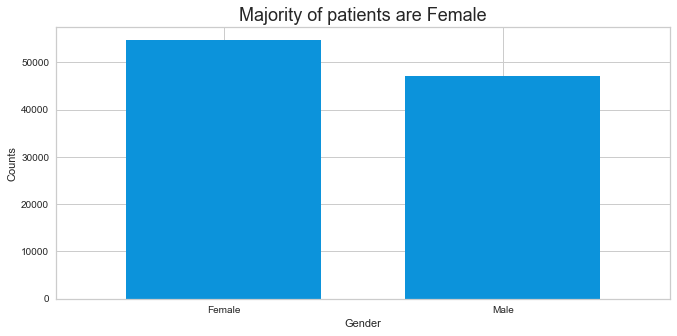

In [34]:
df['gender'].value_counts().plot(kind='bar',width=0.7,color='#0C93DB',figsize=(11,5),rot='horizontal')
plt.title('Majority of patients are Female',size=18)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.show()

In [35]:
# Change all >30 and NO readmitted to NO 
df['readmitted'] = df['readmitted'].map({'NO':'NO','>30':'NO','<30':'YES'}) 

In [36]:
df['readmitted'].value_counts()

NO     90409
YES    11357
Name: readmitted, dtype: int64

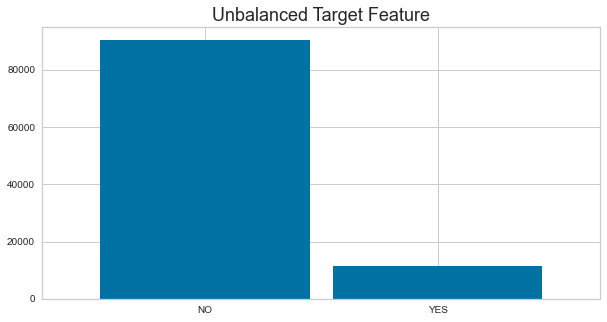

In [37]:
df['readmitted'].value_counts().plot(kind='bar',width=0.9,rot='horizontal',figsize=(10,5)) 
plt.title('Unbalanced Target Feature',size=18)
plt.show()

### EDA

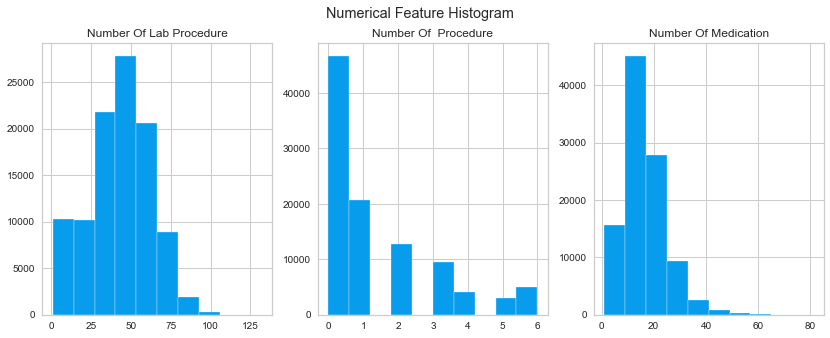

In [38]:
# Function that takes numerical data and create histogram 
fig,ax = plt.subplots(1,3,figsize=(14,5))

ax[0].hist(df['num_lab_procedures'],color='#089CEC',edgecolor='white') 
ax[0].set(title='Number Of Lab Procedure')
ax[1].hist(df['num_procedures'],color='#089CEC',edgecolor='white')
ax[1].set(title='Number Of  Procedure')
ax[2].hist(df['num_medications'],color='#089CEC',edgecolor='white')
ax[2].set(title='Number Of Medication')
plt.suptitle('Numerical Feature Histogram')
plt.show()

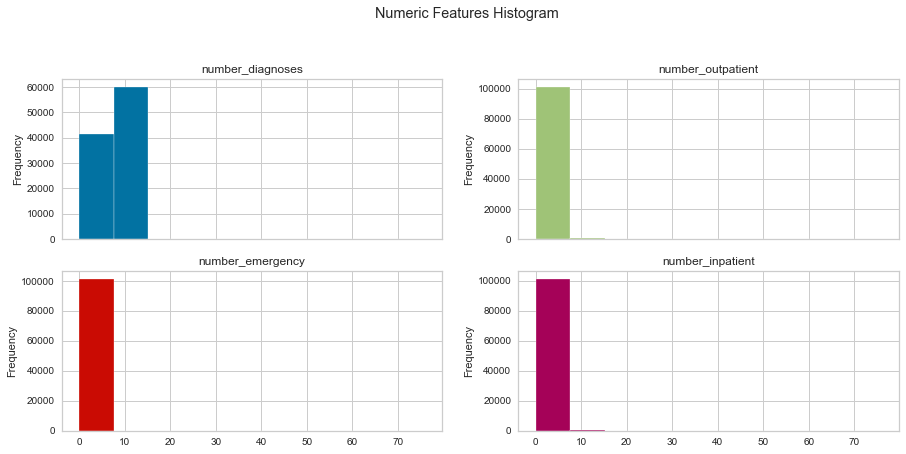

In [39]:
df.plot(kind='hist',y=['number_diagnoses','number_outpatient', 'number_emergency', 'number_inpatient'],
        edgecolor='white',figsize=[15,10],
        title=['number_diagnoses','number_outpatient', 'number_emergency', 'number_inpatient'],
        subplots=True,layout=(3,2),legend=False)
plt.suptitle('Numeric Features Histogram')
plt.show()

In [40]:
# encode target feature 
df['readmitted']=df['readmitted'].map({'YES':1,'NO':0}) 

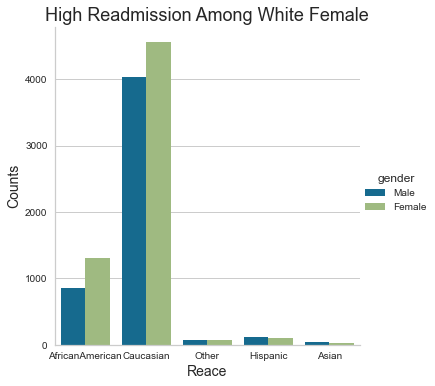

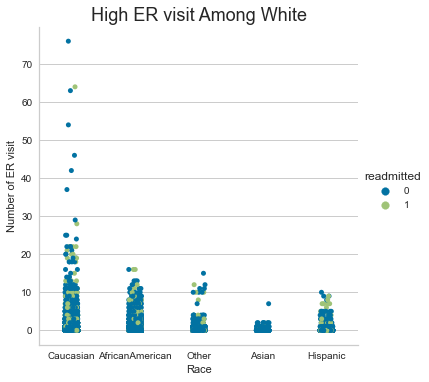

In [41]:
# Fix this plot 

# Among all the pepople who are readmitted what race and gender most likely to readmite

dat = df.loc[df['readmitted']==1,['race','gender']] 
#fig, ax = plt.subplots(1,2,figsize=(13,6))
sns.catplot(x='race',hue='gender',kind='count',data=dat,ax=ax[0])
plt.title('High Readmission Among White Female',size=18)
plt.xlabel('Reace',size=14)
plt.ylabel('Counts',size=14)
sns.catplot(x="race", y="number_emergency", hue="readmitted",  data=df,ax=ax[1])
plt.title('High ER visit Among White',size=18)
plt.xlabel('Race')
plt.ylabel('Number of ER visit')

plt.show()

In [42]:
#categorial_feature_count = len(categorical_features)
#plt.figure(figsize=(10, 6*categorial_feature_count))
#for feature in categorical_features:
#    categorical_explanatory_binary_response_chart(df, feature, 'readmitted')

### What age group people spends more time in the hospital among all readmitted patients ?

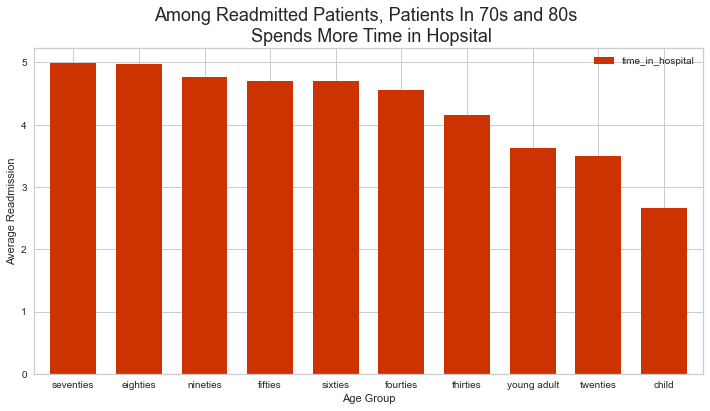

In [43]:

readmit_age= df.loc[df['readmitted']==1,['time_in_hospital','AgeGroup']].groupby(['AgeGroup']).mean()

readmit_age.sort_values(by='time_in_hospital',ascending=False).reset_index().plot(kind='bar',x='AgeGroup',
                                                                                  y='time_in_hospital',
                                                                                  figsize=(12,6),
                                                                                  width=.7,
                                                                                  rot='horizontal',
                                                                                  color='#cc3300')

plt.title('Among Readmitted Patients, Patients In 70s and 80s \n Spends More Time in Hopsital',size=18)
plt.ylabel('Average Readmission')
plt.xlabel('Age Group')
plt.show()


What is the distribution of time at hospital based on if readmission is YES or NO

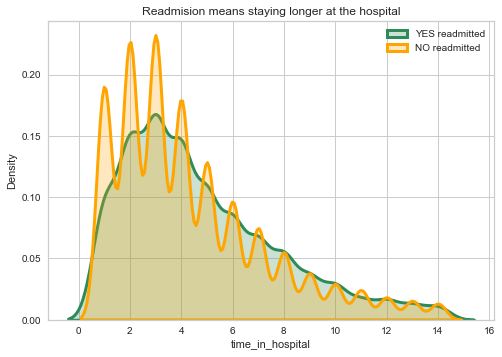

In [44]:
sns.distplot(df.loc[df['readmitted']==1,'time_in_hospital'],color='seagreen',hist=False,kde=True,
           kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "YES readmitted") 
sns.distplot(df.loc[df['readmitted']==0,'time_in_hospital'],color='orange',hist=False,kde=True,
            kde_kws={'shade':True,'linewidth':3},label='NO readmitted') 
plt.legend() 
plt.title('Readmision means staying longer at the hospital')
plt.show() 

In [45]:
df.head(5) 

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
0,Caucasian,Female,NULL,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,child,Not Mapped,Physician Referral
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,young adult,Discharged to home,Emergency Room
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,twenties,Discharged to home,Emergency Room
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,thirties,Discharged to home,Emergency Room
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,fourties,Discharged to home,Emergency Room


#### Realation Of Readmission With admission source typea and admission type

Plot on the left shows that the patients is more likely to get readmitted again in less than 30 days if they are a 
transfer patients from hospital inpt/same fac reslt in a sep claaim. 
And the plot on the right shows that if a patient is ER patients they are more than likely to readmit again in less than 30 days 

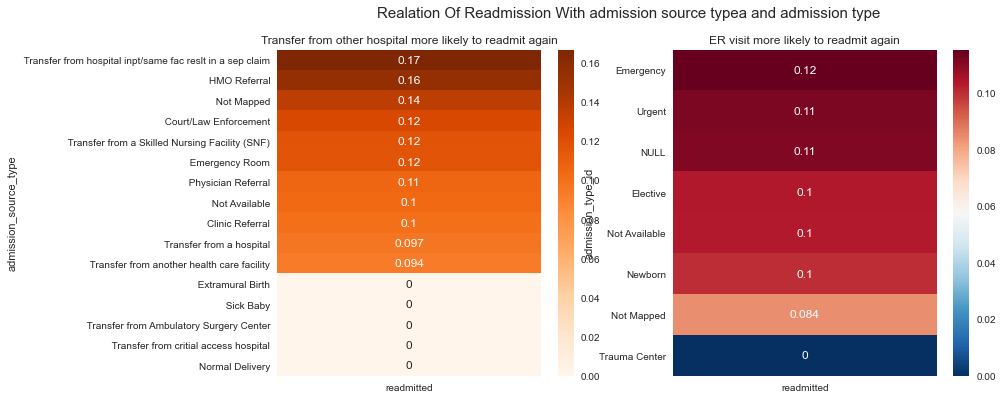

In [46]:
fig,ax = plt.subplots(1,2,figsize=(13,6))
sns.heatmap(df[['admission_source_type','readmitted']].groupby(by='admission_source_type').mean().sort_values(by='readmitted',ascending=False),annot=True,cmap='Oranges',ax=ax[0],label=False)
ax[0].set(title='Transfer from other hospital more likely to readmit again')
ax[1].set(title='ER visit more likely to readmit again')

sns.heatmap(df[['admission_type_id','readmitted']].groupby(by='admission_type_id').mean().sort_values(by='readmitted', ascending=False),annot=True,cmap='RdBu_r',ax=ax[1])
plt.suptitle('Realation Of Readmission With admission source typea and admission type',size=15)
plt.show()


Among patients who will not get readmited in less than 30 days, ***62.67%*** were discharged to their home 

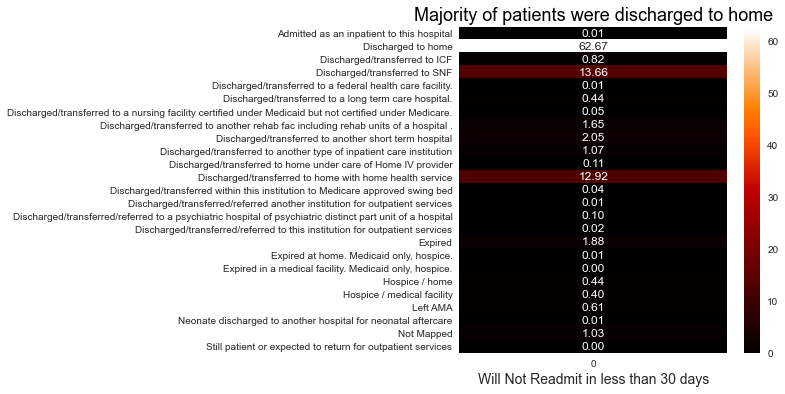

In [47]:
df_discharge = df.loc[df['readmitted']==0,['discharge_disposition_type','readmitted']]

ct = pd.crosstab(df_discharge['discharge_disposition_type'], 
                 df_discharge['readmitted'],
                    normalize=True ).round(4)*100 

plt.figure(figsize=(6,6))
discharge_readmit = sns.cubehelix_palette(start=0,light=1,as_cmap=True)
sns.heatmap(ct,annot=True,cmap='gist_heat',fmt='.2f',linewidths=.0)
plt.xlabel('Will Not Readmit in less than 30 days',size=14)
plt.ylabel('',size=14)
plt.title('Majority of patients were discharged to home',fontsize=18,color='black')
plt.show()

In [48]:
#df_discharge = df.loc[df['readmitted']==0,['discharge_disposition_type','readmitted']]

#ct = pd.crosstab(df['discharge_disposition_type'], 
#                  df['readmitted'],
#                     normalize=True ).round(4)*100 
#ct 


#plt.figure(figsize=(12,8))
#discharge_readmit = sns.cubehelix_palette(start=0,light=1,as_cmap=True)
#sns.heatmap(ct,annot=True,cmap='gist_heat',fmt='.2f',linewidths=.0)
#plt.xlabel('',size=14)
#plt.ylabel('',size=14)
#plt.title('',fontsize=18,color='black')
#plt.show()

#### Correlation of numerical features 

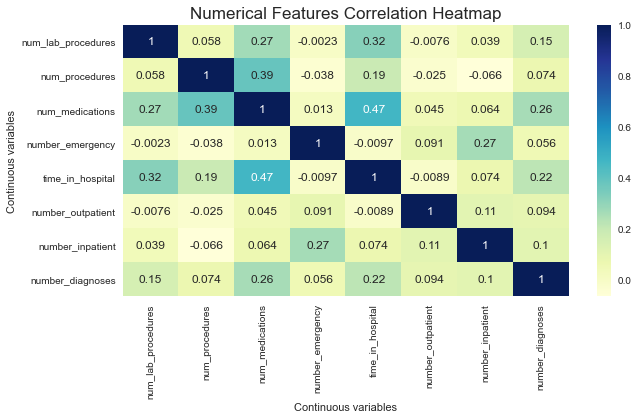

In [49]:
plt.figure(figsize=(10,5))
corr=df[['num_lab_procedures','num_procedures','num_medications','number_emergency','time_in_hospital','number_outpatient','number_inpatient','number_diagnoses']].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.title("Correlation matrix", y=-0.75)
plt.xlabel("Continuous variables")
plt.ylabel("Continuous variables")
plt.title('Numerical Features Correlation Heatmap',size=17)
plt.show()


In [50]:
corr=df[['num_lab_procedures','num_procedures','num_medications','number_emergency','time_in_hospital','number_outpatient','number_inpatient','number_diagnoses']]
#sns.pairplot(data=corr, hue="readmitted")


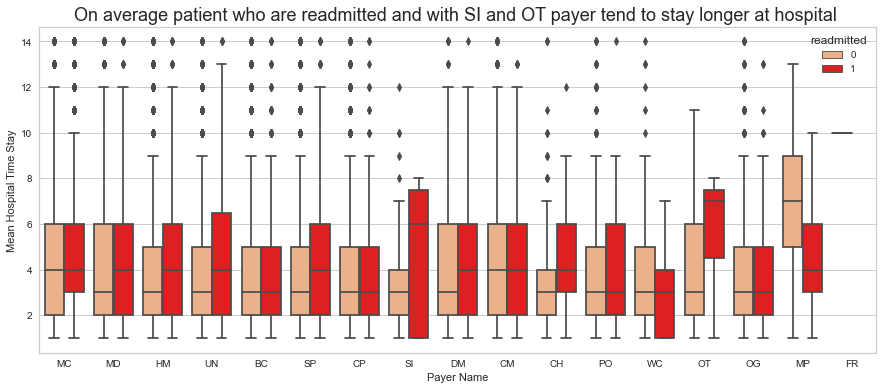

In [51]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['payer_code'],y=df['time_in_hospital'],hue=df['readmitted'],palette=["#FAAE7B",'red'])
plt.xlabel('Payer Name')
plt.ylabel('Mean Hospital Time Stay')
plt.title('On average patient who are readmitted and with SI and OT payer tend to stay longer at hospital ',size=18)
plt.show()

### Replacing all Not available, Not mapped, Null with eighter Unknown or NaN

In [52]:
# df['max_glu_serum'] = df['max_glu_serum'].map({'>200':'diabetic',
#                                                '>300':'critical high',
#                                                'None':'unknown',
#                                                'Norm':'Normal'})
# df['admission_type_id'] = df['admission_type_id'].replace('Not Available','Unknown')
# df.loc[df['admission_type_id']=='NULL','admission_type_id'] = np.nan
# df.loc[df['admission_type_id']=='Not Mapped','admission_type_id'] = np.nan
# df = df.rename(columns={'change':'diabetic_medication_change'}) 


#### Working with ICD9 code. Grouping Diagnostic columns with CD-9-CM Chapters Code Range
###### Ref:https://icd.codes/icd9cm

In [53]:
#Create custom code range feature for diag_1, diag_2, diag_3 columns
groupDiagnosticColumns(df, 'diag_1')
groupDiagnosticColumns(df, 'diag_2')
groupDiagnosticColumns(df, 'diag_3')

In [54]:
df.head()

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type,diag_1_Cat,diag_2_Cat,diag_3_Cat
0,Caucasian,Female,NULL,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,child,Not Mapped,Physician Referral,240-279,NaN,NaN
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276.00,250.01,255.0,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,young adult,Discharged to home,Emergency Room,240-279,240-279,240-279
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648.00,250.00,100027.0,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,twenties,Discharged to home,Emergency Room,630-679,240-279,V01-V91
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8.00,250.43,403.0,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,thirties,Discharged to home,Emergency Room,001-139,240-279,390-459
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197.00,157.00,250.0,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,fourties,Discharged to home,Emergency Room,140-239,140-239,240-279


In [63]:
type(df["diag_1_Cat"].astype(str))
df["gender"].shape
#impute_Features('diag_1_Cat')

(101766,)

##### Dropping diag_1, diag_2, diag_3 as we have created range features

In [ ]:
# Drop unnecessary columns 
df = df.drop(['diag_1','diag_2','diag_'],axis=1)

In [58]:
df['gender']

0         Female
1         Female
2         Female
3           Male
4           Male
           ...  
101761      Male
101762    Female
101763      Male
101764    Female
101765      Male
Name: gender, Length: 101766, dtype: object

##### Imputing missing data 

In [67]:
#Impute race
impute_Features('race',df)

#Impute payer_code
impute_Features('payer_code',df)

#Impute medical_specialty
impute_Features('medical_specialty',df)

#Impute admission_source_type
impute_Features('admission_source_type',df)

#Impute diag_1_Cat
impute_Features('diag_1_Cat',df)

#Impute diag_2_Cat
impute_Features('diag_2_Cat',df)

#Impute diag_3_Cat
impute_Features('diag_3_Cat',df)

df = grouper_impute(df, 'AgeGroup', grouper_impute = 'diag_1_Cat', replace_val = 0, transfrmtn = 'mode')


ValueError: Expected 2D array, got 1D array instead:
array=['Caucasian' 'Caucasian' 'AfricanAmerican' ... 'Caucasian' 'Caucasian'
 'Caucasian'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [97]:
df = grouper_impute(df, 'AgeGroup', grouper_impute = 'diag_1_Cat', replace_val = 0, transfrmtn = 'mode')

ValueError: 'mode' is not a valid function name for transform(name)

In [95]:
df['diag_1_Cat'].mode()

0    390-459
Name: diag_1_Cat, dtype: category
Categories (19, object): ['001-139' < '140-239' < '240-279' < '280-289' ... '780-799' < '800-999' < 'V01-V91' < 'E000-E999']

In [ ]:
#Instantiate scikit-learn's SimpleImputer to replace "nan" values with the mode value
fill_nan = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

# Imputing race with mode
df['race']= fill_nan.fit_transform(df.loc[:,'race'].values.reshape(-1,1))

In [ ]:
fill_nan_payer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df['payer_code'] = fill_nan_payer.fit_transform(df.loc[:,'payer_code'].values.reshape(-1,1))

In [ ]:
fill_nan_medical_specialty = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df['medical_specialty'] = fill_nan_medical_specialty.fit_transform(df.loc[:,'medical_specialty'].values.reshape(-1,1))

In [ ]:
fill_nan_admission_source_type = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df['admission_source_type'] = fill_nan_admission_source_type.fit_transform(df.loc[:,'admission_source_type'].values.reshape(-1,1))

In [ ]:
fill_nan_payer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df['payer_code'] = fill_nan_payer.fit_transform(df.loc[:,'payer_code'].values.reshape(-1,1))

In [ ]:
df.head() 

In [ ]:
#set(df['medical_specialty'])

#set(df['medical_specialty'])

In [ ]:

df.isna().sum()/df.shape[0]*100

#### Dummy Code Variables 

In [79]:
features_of_interest_encoding =['race', 'gender', 'admission_type_id', 'payer_code',
       'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 
       'diabetesMed', 'AgeGroup', 'discharge_disposition_type',
       'admission_source_type', 'diag_1_Cat', 'diag_2_Cat', 'diag_3_Cat']

In [80]:
df_dummy_enc = create_dummy_encod(df, features_of_interest_encoding, drop_first_cat=True, sparsity=True)

In [81]:
df_dummy_enc.shape

(101766, 269)

#### Scale the Numerical Variables 

#### Get the final dataset ready to model 

#### Split datasets into training and testing 

In [86]:
y = df_dummy_enc['readmitted'].values
X = df_dummy_enc.drop(columns = ['readmitted'], axis = 1).values

In [87]:
# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234, stratify=y)

#### Fit initial logistic regression model 

We will use 10-fold cross validation to determine a baseline accuracy score for logistic regression.

In [94]:
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb
cv = model_selection.StratifiedKFold(n_splits=10,shuffle=True, random_state=1234)
model = linear_model.LogisticRegression(solver='lbfgs', random_state=1234, max_iter = 1e5)
stratified_cross_validate(model, X, y, cv=cv)

Fold Scores:
 
[nan nan nan nan nan nan nan nan nan nan]
 
Mean Accuracy:  nan
Mean Fit Time:  0.6795612573623657
Mean Score Time:  0.0
CV Time:  4.840420722961426


#### Get important features 

#### Perform hyperparameter tunning 

#### Cross validation 

#### Get prediction on test set 

#### Evaluate the model 
  - Accuracy
  - Precision and Recall
  - ROC curve 
  

#### Interpret the Result 